In [64]:
import numpy as np
import os
import matplotlib.pyplot as plt # Import pyplot
import tensorflow as tf

In [65]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("slothkong/10-monkey-species")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/slothkong/10-monkey-species/versions/2


In [66]:
print(path)


/root/.cache/kagglehub/datasets/slothkong/10-monkey-species/versions/2


In [67]:

train_image_path = os.path.join(path, "training", "training")
valid_image_path = os.path.join(path, "validation", "validation")

train_dir = os.path.join(train_image_path)
validation_dir = os.path.join(valid_image_path)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 1097 files belonging to 10 classes.


In [68]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

Found 272 files belonging to 10 classes.


Show the first nine monkeys

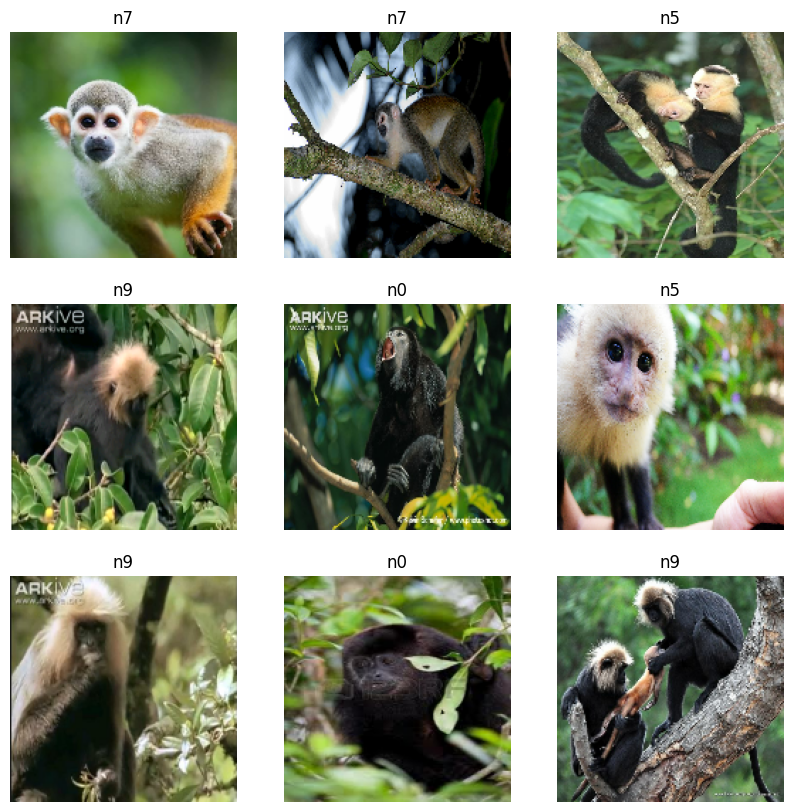

In [69]:
classnames = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) # Use plt.subplot instead of plt.subplots
    plt.imshow(images[i].numpy().astype("uint8")) # Use images[i] and labels[i]
    plt.title(classnames[labels[i]])
    plt.axis("off")

In [70]:
raw_val = tf.keras.utils.image_dataset_from_directory(
    valid_image_path, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)
val_batches = tf.data.experimental.cardinality(raw_val)
test_dataset = raw_val.take(val_batches // 5)
validation_dataset = raw_val.skip(val_batches // 5)


Found 272 files belonging to 10 classes.


In [71]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 1


Configue AUTOTUNE

In [72]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use Data Augmentation

In [73]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

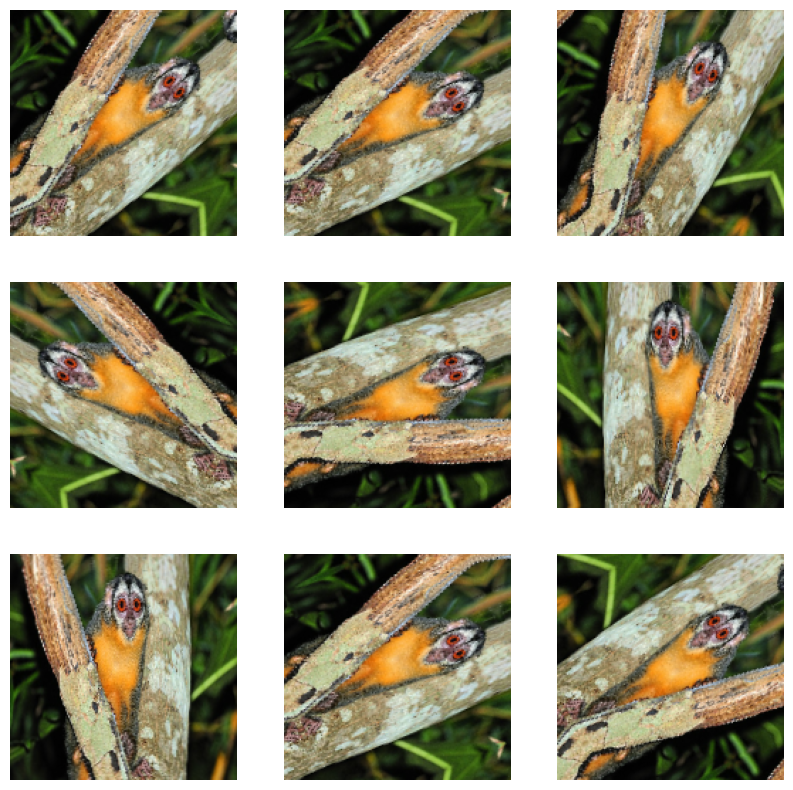

In [74]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [75]:
#Rescalse images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [76]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create base model using MobileNetV2

In [77]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [78]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [79]:
base_model.trainable=False

In [80]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [81]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [82]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [83]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [84]:
# compile: sparse_categorical_crossentropy pairs with softmax outputs
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # from_logits=False (default)
    metrics=['accuracy']
)

# --- TRAIN ---
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5
)

# --- Fine-tune ---
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_ft = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5
)

# final eval
model.evaluate(test_dataset)


Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.0992 - loss: 3.0090 - val_accuracy: 0.1417 - val_loss: 2.4456
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 375ms/step - accuracy: 0.1876 - loss: 2.3912 - val_accuracy: 0.2625 - val_loss: 2.0732
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.2563 - loss: 2.0836 - val_accuracy: 0.4250 - val_loss: 1.7647
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.4013 - loss: 1.7443 - val_accuracy: 0.5500 - val_loss: 1.5069
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 370ms/step - accuracy: 0.5052 - loss: 1.5187 - val_accuracy: 0.6458 - val_loss: 1.3015
Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 421ms/step - accuracy: 0.4383 - loss: 1.6964 - val_accuracy: 0.7500 - val_loss: 1.0682
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step - accuracy: 0.6010 - loss: 1.3118 - val_accuracy: 0.8167 - val_loss: 0.8825
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.6764 - loss: 1.1066 - val_accuracy: 0.

[0.3552825450897217, 0.96875]

In [85]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,349,216 (20.41 MB)

 Trainable params: 1,539,210 (5.87 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 3,078,422 (11.74 MB)

# History Plots

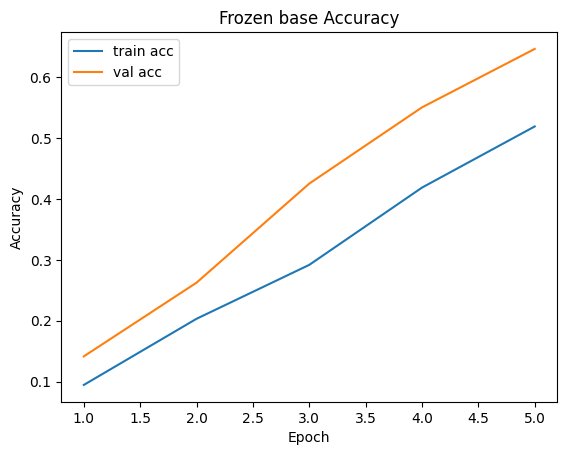

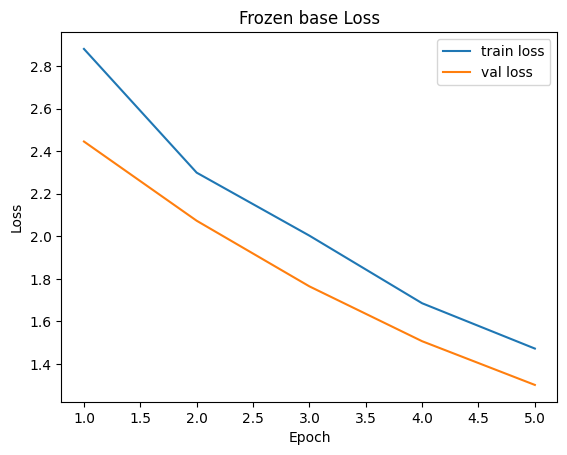

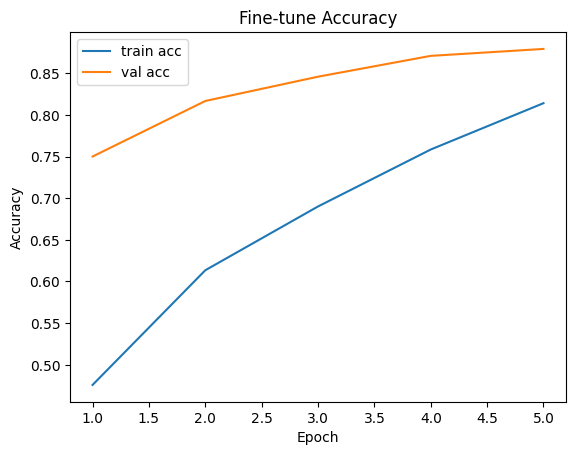

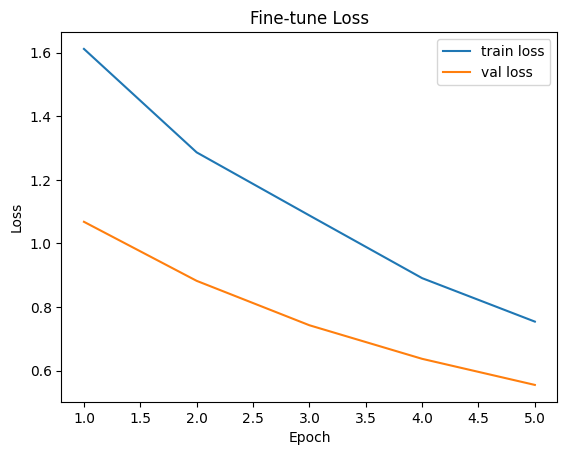

In [86]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix=""):
    acc  = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, label='train acc')
    plt.plot(epochs, val_acc, label='val acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plot_history(history, "Frozen base")
plot_history(history_ft, "Fine-tune")


# Sample predictions

Found 1097 files belonging to 10 classes.


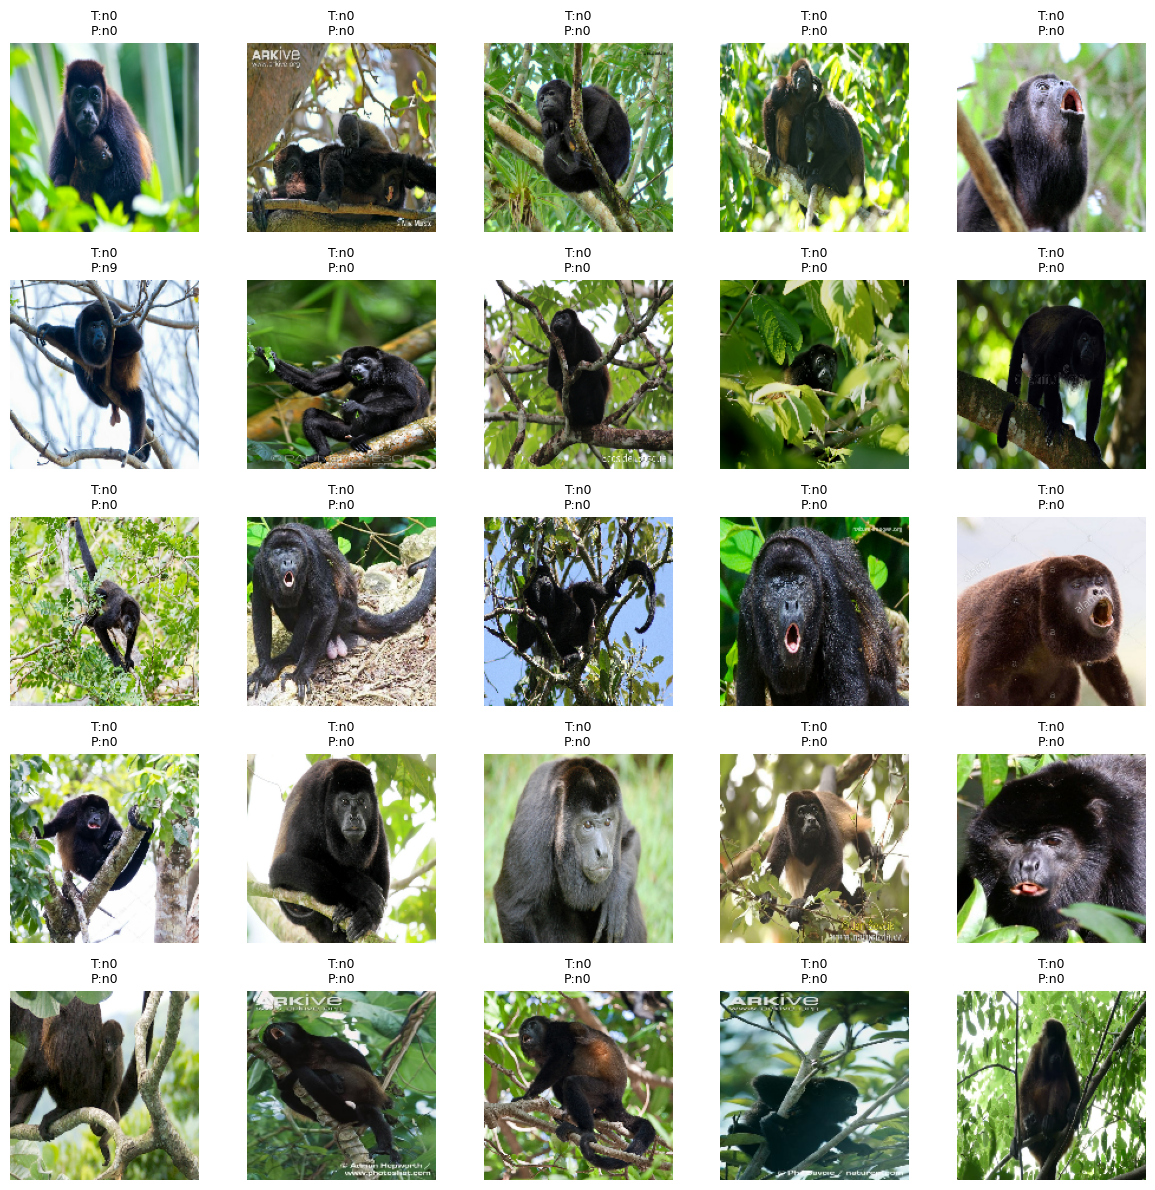

In [88]:
# Access class_names from the original dataset before prefetching
# The original train_dataset was created in cell `oIh8S488AbVy`
class_names = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE).class_names

# collect at least 25 examples
x_list, y_true = [], []
for x, y in test_dataset:
    x_list.append(x); y_true.extend(y.numpy())
    if sum(len(b) for b in x_list) >= 25: break

x_all = tf.concat(x_list, axis=0)[:25]
y_true = np.array(y_true[:25])

pred_probs = model.predict(x_all, verbose=0)
y_pred = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_all[i].numpy().astype("uint8"))
    t = class_names[y_true[i]]
    p = class_names[y_pred[i]]
    ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()

# Parameter Tuning Table

In [89]:
import pandas as pd

runs = []

def log_run(tag, params, hist, eval_name="val"):
    best_acc = max(hist.history[f'{eval_name}_accuracy'])
    best_loss = min(hist.history[f'{eval_name}_loss'])
    entry = {"tag": tag, "best_val_acc": best_acc, "best_val_loss": best_loss}
    entry.update(params)
    runs.append(entry)

# Example after each training phase:
log_run("frozen_base",
        {"batch_size": BATCH_SIZE, "img_size": IMG_SIZE, "lr": 1e-4, "unfrozen_layers": 0,
         "augmentation": "flip+rot(0.2)", "label_smoothing": 0.0},
        history)

log_run("fine_tune_last_30",
        {"batch_size": BATCH_SIZE, "img_size": IMG_SIZE, "lr": 1e-5, "unfrozen_layers": 30,
         "augmentation": "flip+rot(0.2)", "label_smoothing": 0.0},
        history_ft)

pd.DataFrame(runs)


tag  best_val_acc  best_val_loss  batch_size    img_size  \
0        frozen_base      0.645833       1.301493          32  (160, 160)   
1  fine_tune_last_30      0.879167       0.555310          32  (160, 160)   

        lr  unfrozen_layers   augmentation  label_smoothing  
0  0.00010                0  flip+rot(0.2)              0.0  
1  0.00001               30  flip+rot(0.2)              0.0